In [1]:
import xarray
import pygmt
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
from IPython.display import display

In [2]:
ds = xarray.open_dataset("../data/MIROC_outputs/ctrl_MIROC-COSP2.nc")

### Config

In [3]:
# variables

vname='Doppler velocity'
#vname='radar reflectivity'
#vname='terminal velocity'
#vname='vertical air motion'
#vname='Ze-Doppler'
#vname='Ze-terminal'

In [4]:
# meridional zone

zone='tropics'
#zone='mid-north'
#zone='pol-north'
#zone='mid-south'
#zone='pol-south'

In [5]:
# cloud regime
ctype='ALL'
#ctype='stratiform'
#ctype='convective'

In [6]:
# only for Doppler or terminal velocity

zonal_mean = False
#  True: zonal mean
# False: CFED

In [7]:
# only for terminal velocity

weight_factor='reflectivity'
#weight_factor='mass'
#weight_factor='number'

### internal process

In [8]:
%%capture
# data access

if vname=='Doppler velocity':
    var=ds['dplrw_T']
elif vname=='radar reflectivity':
    var=ds['Zef94_T']
elif vname=='terminal velocity':
    var=ds['vfall_T']
elif vname=='vertical air motion':
    var=ds['gridw_T']


In [9]:
#grids

lat=ds["latitude"].values
lon=ds["longitude"].values

temp=ds["lvtemp_grid"].values
zgrd=ds["lvdBZe_grid"].values
vgrd=ds["lvdplr_grid"].values

In [10]:
# target region
west=0. ; east=360.

if zone=='tropics':
    south=-20.0 ; north= 20.0
elif zone=='mid-north':
    south= 20.0 ; north= 50.0
elif zone=='pol-north':
    south= 50.0 ; north= 90.0
elif zone=='mid-south':
    south=-50.0 ; north=-20.0
elif zone=='pol-south':
    south=-90.0 ; north=-50.0

In [11]:
# location mask
lon_mask = (lon >= west) & (lon <= east)
lat_mask = (lat >= south)&(lat <= north)

mask = lon_mask & lat_mask

index = np.where(mask)[0]

In [12]:
# cloud regime
if ctype=='ALL':
    regime=0
elif ctype=='stratiform':
    regime=1
elif ctype=='convective':
    regime=2

In [13]:
# moment
if weight_factor=='reflectivity':
    nmlz=1
elif weight_factor=='mass':
    nmlz=2
elif weight_factor=='number':
    nmlz=3

In [14]:
if vname=='terminal velocity':
    sel = var.isel(loc=index).isel(regimeID=regime).isel(nrmlzdID=nmlz)
else:
    sel = var.isel(loc=index).isel(regimeID=regime)

if vname=='radar reflectivity':
    window = 2.0
    extent = [ -40.0, 30.0, 20.0, -80.0 ]
    xtics = 5.0 ; ytics = 10.0
else:
    window = 0.2
    extent = [ -6.0, 6.0, 20.0, -80.0 ]
    xtics = 1.0 ; ytics = 10.0

In [15]:
smpl = sel.sum(dim='loc', skipna=True).values
nrm = window * smpl.sum(axis=1, keepdims=True)
nrm = np.broadcast_to(nrm,smpl.shape)

zero_check = (nrm < window)
cfed = np.zeros_like(smpl)

cfed[~zero_check] = smpl[~zero_check]/nrm[~zero_check]
cfed[zero_check] = np.nan

### make figure

In [16]:
colors=np.array(
   [
    [248,248,248,1],#white
    [160,210,255,1],
    [ 33,140,255,1],
    [  0, 65,255,1],
    [  0,185,  0,1],
    [250,245,  0,1],
    [255,153,  0,1],
    [255, 40,  0,1],
    [180,  0,104,1],
    [ 45, 45, 45,1],
   ],dtype=np.float64
)
colors[:,:3] /=256
color_listed=ListedColormap(colors)
color_linear=LinearSegmentedColormap.from_list('color_linear',colors=colors)

In [17]:
%%capture
plt.ioff()

fig, ax = plt.subplots(figsize=(16,9))
im = ax.imshow(cfed,
                extent=extent,
                interpolation='nearest',
                origin='upper',
                vmax=5.0,
                cmap=color_linear,
                aspect='auto')

ax.set_title("CFED Map at Fixed Condition", fontsize=32, pad=16)

ax.set_xlabel("Doppler velocity axis (index or m/s)",fontsize=22)
ax.set_ylabel("Temperature axis (index or degC)",fontsize=22)

ax.xaxis.set_major_locator(MultipleLocator(xtics))
ax.yaxis.set_major_locator(MultipleLocator(ytics))
ax.tick_params(axis='both', which='major', labelsize=18)

cbar = fig.colorbar(im, ax=ax,
                    orientation='vertical',
                    pad=0.02,
                    fraction=0.045,
                    shrink=1.0)
cbar.set_label("", fontsize=13)
cbar.ax.tick_params(labelsize=16)


fig.tight_layout()

### results

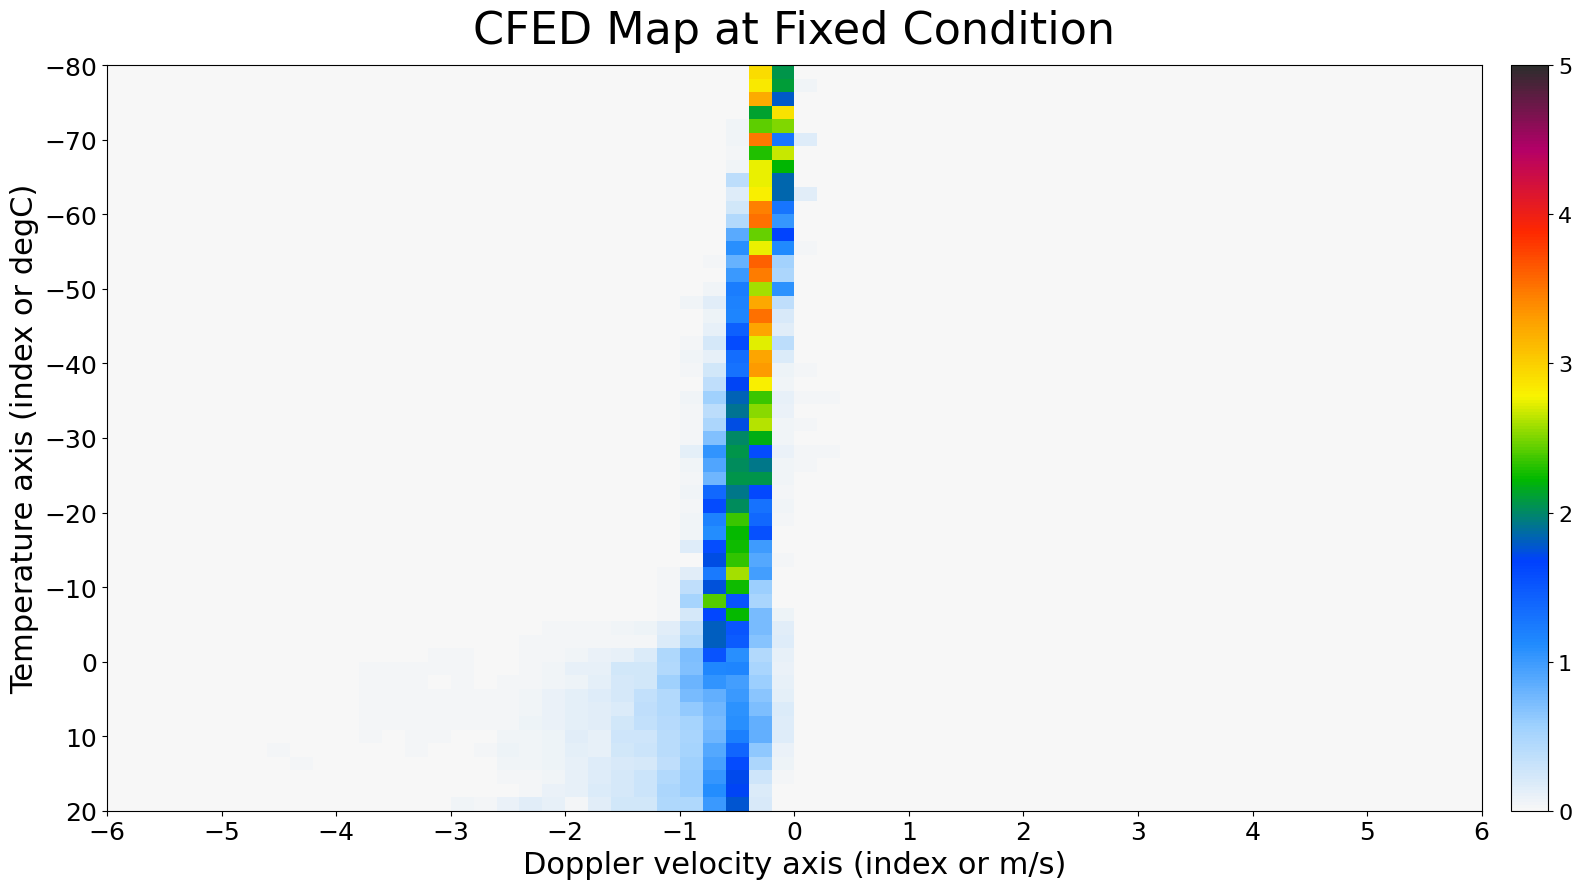

In [18]:
display(fig)